# [NTDS'19] assignment 2: learning with graphs
[ntds'19]: https://github.com/mdeff/ntds_2019

[Clément Vignac](https://people.epfl.ch/clement.vignac), [EPFL LTS4](https://lts4.epfl.ch) and
[Guillermo Ortiz Jiménez](https://gortizji.github.io), [EPFL LTS4](https://lts4.epfl.ch).

## Students

* Team: `6`
* Students: `Altinigne, Can Yilmaz`,`Banjac, Jelena`,`Kypraiou, Sofia`,`Sioulas, Panagiotis` 

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

In this assignment you will experiment with the main concepts of spectral graph theory, as well as familizarize yourself with the main data science techniques for network data.

The assignment is made of three parts:
1. [Spectral Graph Theory](#sgt)
1. [Regularization on graphs with Graph Signal Processing](#gsp)
1. [Machine Learning on Graphs](#ml)

<a id='sgt'></a>
## Part I: Spectral Graph Theory
### Eigenvectors and eigenvalues

We will start by reviewing some of the main concepts in spectral graph theory and see some of its applications to dimensionality reduction and data clustering. To illustrate the main concepts we will use the standard two moon dataset.

In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform, euclidean
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

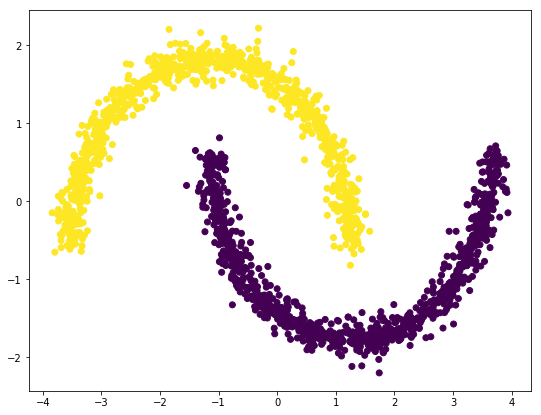

In [2]:
from pygsp.graphs import TwoMoons

G = TwoMoons(moontype='synthesized', N=2000)
X = G.coords
Y = G.labels.astype(int)

plt.figure(figsize=(9,7))
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.show()

In [3]:
X.shape

(2000, 2)

#### Question 1: Graph construction
Build a similarity graph using the euclidean distance between data points.   
**Note:** Use an RBF kernel to set the edge weights $w_{ij}=\exp(-||x_i- x_j||_2^2 / ~ 2 \sigma^2)$ of your adjacency and threshold the ones with the smallest magnitude.

In [4]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    n = X.shape[0]
    adjacency = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1,n):
            w = np.exp(-euclidean(X[i], X[j])**2/(2*sigma**2))
            adjacency[i, j] = adjacency[j, i] = w if w > epsilon else 0
    
    return adjacency

sigma=0.85, epsilon=0.64216719914479


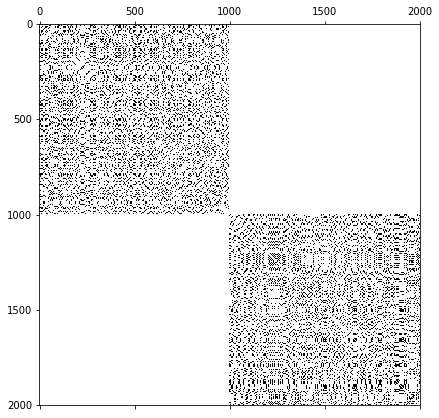

In [5]:
sigma = 0.85
epsilon = np.exp(-0.8**2/(2*sigma**2))
print(f"sigma={sigma}, epsilon={epsilon}")

adjacency = epsilon_similarity_graph(X, sigma=sigma, epsilon=epsilon)
plt.figure(figsize=(7,7))
plt.spy(adjacency)
plt.show()

<div class="alert alert-success">
    <b>NOTE (for us):</b> 
    Edge weights (w) are set with RBF kernel:  
    
   - range from 0 to 1
   - decreases with distance (e.g. 0 for far points, 1 to same/close points)
   
The goal is to have as many connections as possible in $A[:1000,:1000]$ and $A[1000:,1000:]$ regions, and no connections otherwise. So, we want small distances to give high weight to that edge.
When $\sigma$->0 all edges will be given the small weight.
When $\sigma$->1, the edges that are clossest will be given high weight. 
</div>

How do you choose `sigma`?

<div class="alert alert-info">
    <b>ANSWER:</b> 
    We can choose any $\sigma$ value since it will be filtered out with $\epsilon$. However, we will prefer the higher sigma value since it will give more weight on the edges of small distances. We choose $\sigma$ = <b>0.85</b>.
</div>

How do you choose the threshold `epsilon`?

<div class="alert alert-info">
    <b>ANSWER:</b> 
    Depending on the $\sigma$ value, we choose $\epsilon$ value based on equation  $\epsilon = \exp(-0.35^2 / ~ 2 \sigma^2)$. The value 0.35 is measured from the Two Moons plot, where it is the distance between one end of the one moon and the middle point of the other moon. We calculate it $\epsilon$ = <b>0.92</b>.
</div>

#### Question 2: Laplacian
Build the combinatorial and normalized graph laplacians for this dataset.

In [6]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    # Your code here
    n = adjacency.shape[0]
    
    # D is degree matrix (in our case the degree is represented with the weight of edge)
    D = np.diag(np.sum(adjacency, axis=1))
    L = D - adjacency
    
    if not normalize:
        return L

    # L_norm = D^(-1/2) @ L @ D^(-1/2)
    D_norm = np.diag(np.sum(adjacency, axis=1)**(-0.5))
    L_norm = D_norm @ L @ D_norm
    
    return L_norm

In [7]:
laplacian_comb = compute_laplacian(adjacency, normalize=False)
laplacian_norm = compute_laplacian(adjacency, normalize=True)

#### Question 3: Eigendecomposition

For both Laplacian matrices, compute the eigendecomposition $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues. Make sure that the eigenvalues are ordered, i.e., $\lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$. 

Justify your choice of a solver for the eigendecomposition.

<div class="alert alert-info">
    <b>ANSWER:</b> 
    The Laplacian is always a symmetric real valued matrix and therefore a Hermitian matrix as well. So we can use the solver for sparse Hermitian matrices.
</div>

In [8]:
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    # Your code here
    lamb, U = np.linalg.eig(laplacian)
    
    #order the eigenvalues
    sortInd = np.argsort(lamb)
    
    return lamb[sortInd], U[:, sortInd]

In [9]:
lamb_comb, U_comb = spectral_decomposition(laplacian_comb)
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)

#### Question 4: Interpretation
We plot the sorted eigenvalues as a function of their index:

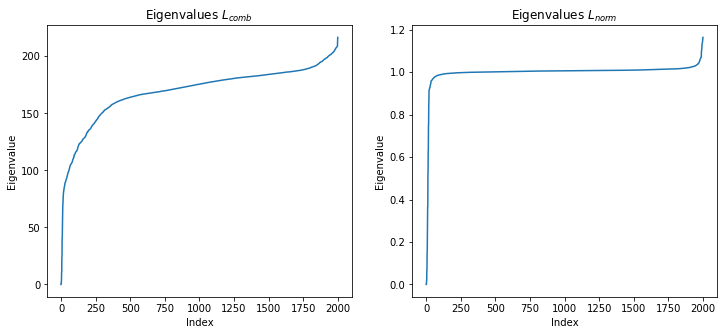

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(lamb_comb)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{comb}$')
plt.subplot(122)
plt.plot(lamb_norm)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')
plt.show()

What is the lowest eigenvalue $\lambda_0$ and the corresponding eigenvector $u_0$? Answer for both Laplacian matrices.

<div class="alert alert-info">
    <b>ANSWER:</b> https://github.com/mdeff/ntds_2018/blob/master/milestones/3_spectral_graph_theory_student_solution.ipynb
    If the graph (W) has K connected components, then L has K eigenvectors with an eigenvalue of 0.
</div>

When filtering a signal or computing polynomials, which Laplacian provides the best numerical stability? Justify your answer.

<div class="alert alert-info">
    <b>ANSWER</b> 
    
</div>

#### Question 5: Connected components
The eigendecomposition provides an easy way to compute the number of connected components in the graph. Fill the following function:

In [11]:
def compute_number_connected_components(lamb: np.array, threshold: float):
    """ lamb: array of eigenvalues of a Laplacian
        Return:
        n_components (int): number of connected components.
    """
    # Your code here
    return lamb[lamb < threshold].shape[0]

Tune the parameters $\epsilon$ and $\sigma$ of the similarity graph so that the graph is connected. Otherwise, clustering would be too simple!

sigma=0.1, epsilon=1.9287498479639315e-22


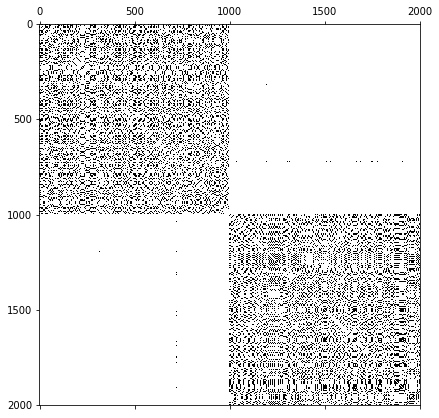

In [12]:
# added cell for tuning the params for graph being connected
sigma = 0.1
epsilon = np.exp(-1**2/(2*sigma**2))
print(f"sigma={sigma}, epsilon={epsilon}")

laplacian_norm = compute_laplacian(adjacency, normalize=True)
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)

adjacency = epsilon_similarity_graph(X, sigma=sigma, epsilon=epsilon)
plt.figure(figsize=(7,7))
plt.spy(adjacency)
plt.show()

In [13]:
print(compute_number_connected_components(lamb_norm, threshold=0.0005))#1e-12))

2


<div class="alert alert-danger">
    <b>Check the output: 1 or 2 components?</b> 
    
</div>

### Spectral clustering

Let us now see one application of spectral graph theory to clustering the two moon dataset.

#### Question 6: Baseline

As a baseline, let us first see how the simplest clustering algorithm, K-means, performs on this dataset. Use K-means to assign a cluster to each point.

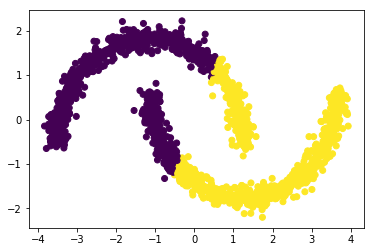

In [14]:
from sklearn.cluster import KMeans

# Your code here
y_pred =  KMeans(n_clusters=2, random_state=0).fit_predict(X) # Vector with cluster assignments

plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

K-means cannot find a good solution to this problem. Why?

<div class="alert alert-info">
    <b>ANSWER</b> 
    K-means clustering aims to partition $n$ observations into $k$ clusters in which each observation belongs to the cluster with the nearest mean. Therefore, the K-means cannot find a good solution to this problem since it is using the absolute location (which in this case are should not be belonging to the same cluster) to determine what poitns fall under which cluster.
</div>

#### Question 7: Spectral clustering

As opposed to naive K-means, spectral clustering doesn't operate on the input space but on the eigenspace of the graph that represents the data. Implement spectral clustering. You can use 
[this tutorial](http://lasa.epfl.ch/teaching/lectures/ML_Phd/Notes/tutoSC.pdf).

In [15]:
class SpectralClustering():
    def __init__(self, n_classes: int, normalize: bool):
        self.n_classes = n_classes
        self.normalize = normalize
        self.laplacian = None
        self.e = None
        self.U = None
        # Your code here
        self.clustering_method =  KMeans(n_clusters=n_classes, random_state=0)
        
    def fit_predict(self, adjacency):
        """ Your code should be correct both for the combinatorial
            and the symmetric normalized spectral clustering.
            Return:
            y_pred (np.ndarray): cluster assignments.
        """
        # Your code here
        self.laplacian = compute_laplacian(adjacency, self.normalize)
        self.e, self.U = spectral_decomposition(self.laplacian)
        self.U = self.U[:,:self.n_classes]
        
        if self.normalize:
            self.U /= np.sqrt(np.sum(self.U**2,axis=1))[:, np.newaxis]
            
        y_pred = self.clustering_method.fit_predict(self.U)
        
        
        return y_pred

Connected components: 1


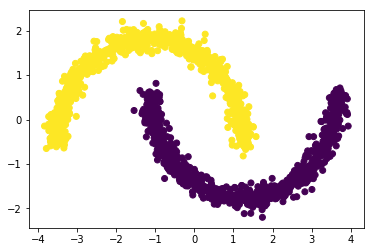

In [16]:
print("Connected components:", compute_number_connected_components(lamb_norm, threshold=1e-12))
spectral_clustering = SpectralClustering(n_classes=2, normalize=True)
y_pred = spectral_clustering.fit_predict(adjacency)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

<div class="alert alert-danger">
    <b>Check the output: 1 or 2 components?</b> 
    
</div>

#### Question 8: On your dataset

Can you think of another 2D dataset in which k-means would badly perform, but spectral clustering would not?
Construct it!
For this question you can import any dataset of your choice, for example from `sklearn.datasets` or `pygsp.graphs`, but you can also get creative and define something of your own. First, create and plot the dataset.

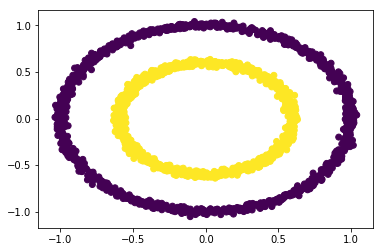

In [17]:
# Your code here
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=2000, random_state=0, noise=0.02, factor=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

Run K-means:

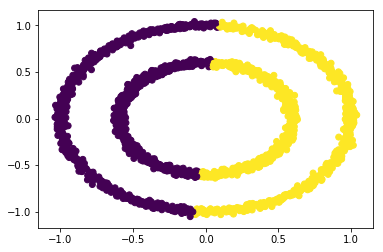

In [18]:
# Your code here
y_pred = KMeans(n_clusters=2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

Create the similarity graph, and run spectral clustering with both the combinatorial and normalized Laplacian matrices:

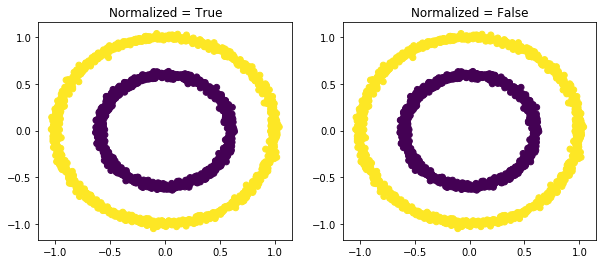

In [19]:
# Your code here
adjacency = epsilon_similarity_graph(X, sigma=0.25, epsilon=0.5)

f, ax = plt.subplots(1,2, figsize=(10,4))
ax = ax.ravel()
norm = [True, False]

for i in range(2):  
    spectral_clustering = SpectralClustering(n_classes=2, normalize=norm[i])
    y_pred = spectral_clustering.fit_predict(adjacency)
    ax[i].scatter(X[:, 0], X[:, 1], c=y_pred)
    ax[i].set_title("Normalized = " + str(norm[i]))

<div class="alert alert-info">
    <b>ANSWER</b> 
    *Comment your results here*
</div>

### Dimensionality Reduction with Laplacian Eigenmaps

Most datasets are very high-dimensional, which means it can be very hard to understand their geometry. Fortunately, there exists multiple  techniques that can help us to reduce the dimensionality of the data, and allow us to visualize it. 

In this part of the assignment we will use MNIST to compare these techniques. Indeed, without dimensionality reduction it would be very difficult to answer questions like: are the different digits clustered together in different areas of space? 

But first, let's load our dataset:

In [20]:
from utils import load_mnist
import numpy as np

X_mnist, y_mnist = load_mnist()
classes = np.unique(y_mnist)

#### Question 9: Laplacian eigenmaps

Most dimensionality reduction algorithms are constructed such that some property of the dataset remains invariant in the lower dimensional representation. Before implementing laplacian eigenmaps, can you say what property of the data does this algorithm preserve?

<div class="alert alert-info">
    <b>ANSWER:</b> 
     We use Laplacian eigenmaps for dimensionality reduction, mapping a network to a vector space and reducing the dimension, while preserving relevant graph properties. It preserves relevant graphs properties such as the number of data points N, while reducing the dimension d. The goal of the Laplacian eigenmap algorithm is to preserve local information optimally. All the point node that are close to each other, meaning nodes connected by an edge with a large weight, must remain close to each other in the embedding (local distances).
</div>

Implement a function that uses Laplacian eigenmaps to do dimensionality reduction.

In [21]:
euclidean(X_mnist[300], X_mnist[301])

2354.3323894471655

In [22]:
sigma= 1400
np.exp(-euclidean(X_mnist[700], X_mnist[701])**2/(2*sigma**2))

0.3749786363042903

In [23]:
e = []
for n in range(10):
    for i in range(n, n+300):
        for j in (i, n+300):
            e.append(euclidean(X_mnist[i], X_mnist[j]))
np.mean(e)

1435.5480691390171

In [24]:
sigma=5000
eps = []
for n in range(10):
    for i in range(n, n+300):
        for j in (i, n+300):
            eps.append(np.exp(-euclidean(X_mnist[i], X_mnist[j])**2/(2*sigma**2)))
print(np.mean(eps))
print(np.median(eps))

0.9234678800162379
0.998242595725834


In [25]:
def laplacian_eigenmaps(X:np.ndarray, dim: int, sigma: float, epsilon: float, normalize: bool, plotting=False):
    """ Return:
        coords (n x dim array): new coordinates for the data points."""
    # Your code here
    adjacency = epsilon_similarity_graph(X, sigma, epsilon)
    if plotting:
        plt.figure(figsize=(7,7))
        plt.spy(adjacency)
        plt.show()
    
    laplacian = compute_laplacian(adjacency, normalize)
    e, U = spectral_decomposition(laplacian)
    
    # solutions are the k first non-trivial eigenvectors of L_norm
    nonZeroInd = np.nonzero(e)[0]
    dimInd = nonZeroInd[:dim+1]  # TODO: was +1
    
    # select the n classes 
    coords = U[:,dimInd]

    return coords

In [26]:
Xcoords = laplacian_eigenmaps(X_mnist, dim=8, sigma=5000, epsilon=0.5, normalize=True, plotting=False);

<div class="alert alert-danger">
    <b>NOTE:</b> 
     Euclidean distance between two images here is very high in comparison to the dataset we had in the questions in the beginning of the notebook. Therefore, the sigma value would need to be very big.
</div>

Use this function to visualize MNIST in 2D. Feel free to play with the different parameters.

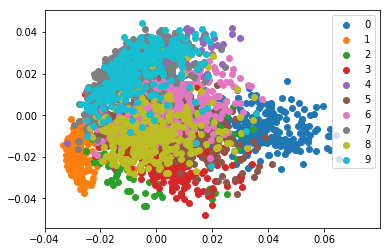

In [27]:
# Your code here
dim = 2

for number, i in enumerate(range(0, 3000, 300)):
    plt.scatter(Xcoords[i:i+300, 1], Xcoords[i:i+300, 2], label=f"{number}")

plt.legend()
plt.show()

Visualize MNIST in 3D:

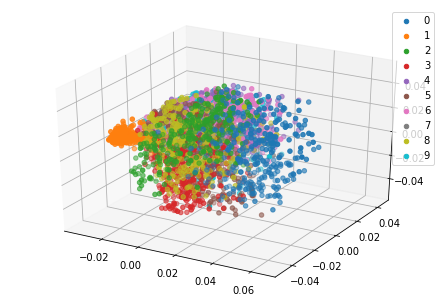

In [28]:
# Your code here
dim = 3

fig = plt.figure()
ax = Axes3D(fig)
for number, i in enumerate(range(0, 3000, 300)):
    ax.scatter(Xcoords[i:i+300, 1], Xcoords[i:i+300, 2], Xcoords[i:i+300,3], label=f"{number}")
plt.legend()
plt.show()

<div class="alert alert-danger">
    <b>NOTE:</b> 
     We also tried to see the result of a different epsilon value, which will concentrate on the MNIST images that are more similar. From the output below we can see that the images of numbers 0 and 2 are tending to be very close in sence of differences. However, all other numbers are clustered around (0, 0) coordinates so we cannot really distinguish them.
</div>

In [29]:
Xcoords = laplacian_eigenmaps(X_mnist, dim=8, sigma=5000, epsilon=0.9, normalize=True, plotting=False);

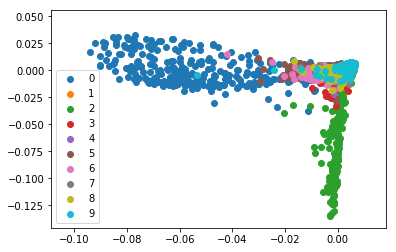

In [30]:
for number, i in enumerate(range(0, 3000, 300)):
    plt.scatter(Xcoords[i:i+300, 1], Xcoords[i:i+300, 2], label=f"{number}")

plt.legend()
plt.show()

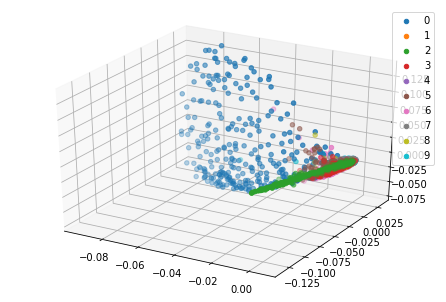

In [31]:
# Your code here
dim = 3

fig = plt.figure()
ax = Axes3D(fig)
for number, i in enumerate(range(0, 3000, 300)):
    ax.scatter(Xcoords[i:i+300, 1], Xcoords[i:i+300, 2], Xcoords[i:i+300,3], label=f"{number}")
plt.legend()
plt.show()

#### Question 10: Comparison with other methods  
We provide the visualization of MNIST with other methods:

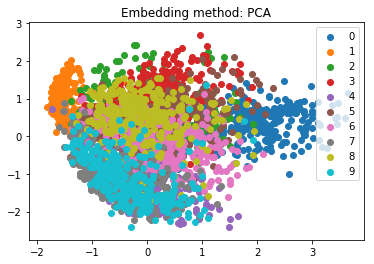

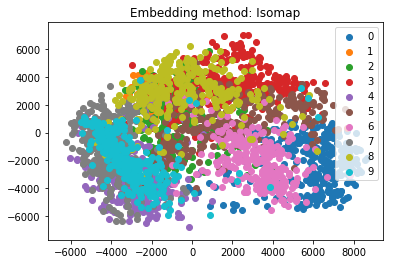

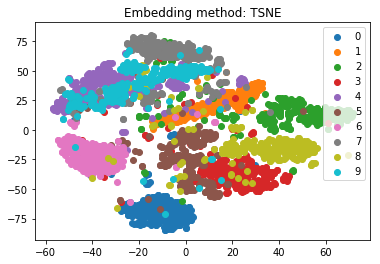

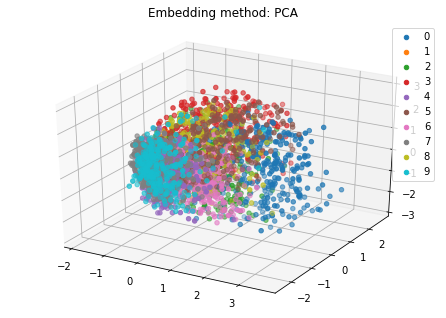

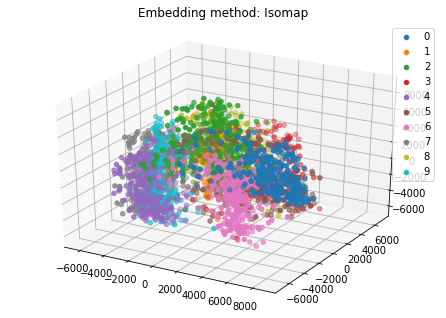

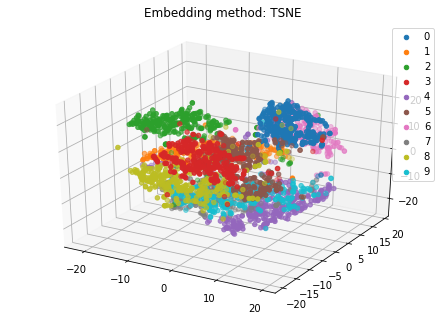

In [32]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

# This cell can take a few minutes to run
run_this_cell = True

if run_this_cell:
    # In 2d
    embeddings = [PCA(n_components=2, copy=True, whiten=True, tol=1e-5),
                  Isomap(n_components=2, n_neighbors=5),
                  TSNE(n_components=2)]

    for embedding in embeddings:
        X_embedded = embedding.fit_transform(X_mnist)
        fig = plt.figure()
        for i in classes:
            mask = y_mnist == i
            plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], label=i)
        plt.legend()
        plt.title('Embedding method: '+ type(embedding).__name__)
        plt.show()

    # In 3d
    embeddings = [PCA(n_components=3, copy=True, whiten=True, tol=1e-5),
                  Isomap(n_components=3, n_neighbors=5),
                  TSNE(n_components=3)]

    for embedding in embeddings:
        X_embedded = embedding.fit_transform(X_mnist)
        fig = plt.figure()
        ax = Axes3D(fig)
        for i in classes:
            mask = y_mnist == i
            ax.scatter(X_embedded[mask, 0], X_embedded[mask, 1], X_embedded[mask, 2], label=i)
        ax.legend()
        ax.title.set_text('Embedding method: '+ type(embedding).__name__)
        plt.show()

In a few words, what are the principles guiding the design of each method? Compare their results.

<div class="alert alert-info">
    <b>ANSWER:</b> 
    https://scikit-learn.org/stable/modules/manifold.html
    
https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
</div>

<a id='gsp'></a>
## Part II: Regularization on graphs with Graph Signal Processing

In this part of the assignment we are going to familiarize ourselves with the main concepts in Graph Signal Processing and regularization on graphs in general. From now on, you can only use the following libraries as well as the functions that you implemented in the previous parts.

In [143]:
import pandas as pd
import numpy as np
from pygsp.graphs import Bunny

In this exercise we will use a nearest-neighbor graph constructed from the Stanford Bunny point cloud included in the PyGSP library.

In [144]:
G = Bunny()
adjacency = np.asarray(G.W.todense())
n_nodes = adjacency.shape[0]

We will use the following function to plot our signals on this graph.

In [145]:
def plot_bunny(x=None, title='', vlim=[-0.03, 0.03]):
    fig = plt.gcf()
    ax = plt.gca()
    if not isinstance(ax, Axes3D):
        ax = plt.subplot(111, projection='3d')
    if x is not None:
        x = np.squeeze(x)

    p = ax.scatter(G.coords[:,0], G.coords[:,1], G.coords[:,2], c=x, marker='o',
                   s=5, cmap='RdBu_r', vmin=vlim[0], vmax=vlim[1])
    ax.view_init(elev=-90, azim=90)
    ax.dist = 7
    ax.set_axis_off()
    ax.set_title(title)
    if x is not None:
        fig.colorbar(p)

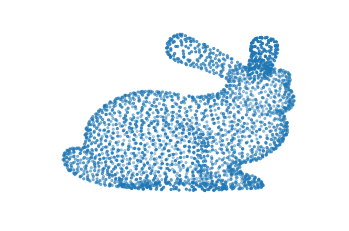

In [146]:
plt.subplot(111, projection='3d')
plot_bunny()

#### Question 11: Graph frequencies

Let us start by constructing the normalized graph laplacians from the adjacency matrix and find its spectral decomposition.

In [147]:
laplacian = compute_laplacian(adjacency, normalize=True)
lam, U = spectral_decomposition(laplacian)

Plot the eigenvalues.

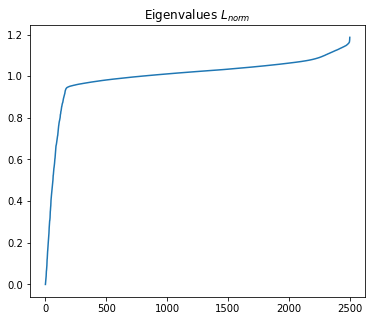

In [148]:
plt.figure(figsize=(6, 5))
plt.plot(lam)
plt.title('Eigenvalues $L_{norm}$')
plt.show()

To make things more clear we will plot some of its eigenvectors (0, 1, 3, 10, 100) as signals on the bunny graph.

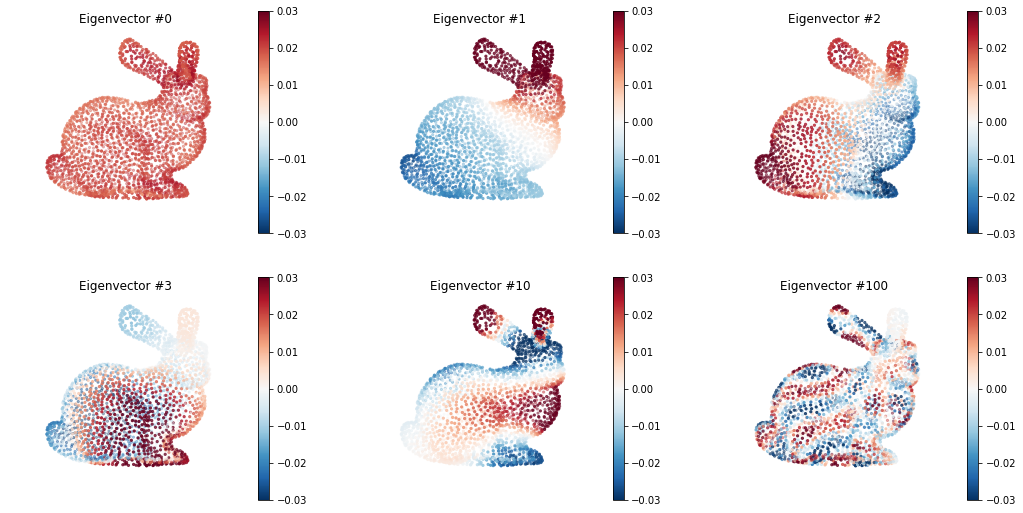

In [149]:
plt.figure(figsize=(18, 9))
plt.subplot(231, projection='3d')
plot_bunny(x=U[:,0], title='Eigenvector #0')
plt.subplot(232, projection='3d')
plot_bunny(x=U[:,1], title='Eigenvector #1')
plt.subplot(233, projection='3d')
plot_bunny(x=U[:,2], title='Eigenvector #2')

plt.subplot(234, projection='3d')
plot_bunny(x=U[:,3], title='Eigenvector #3')
plt.subplot(235, projection='3d')
plot_bunny(x=U[:,10], title='Eigenvector #10')
plt.subplot(236, projection='3d')
plot_bunny(x=U[:,100], title='Eigenvector #100')

What can you say in terms of the variation (smoothness) of these signals? How can the smoothness of a signal be measured?

<div class="alert alert-info">
    <b>ANSWER</b> 
   
</div>

#### Question 12: Graph Fourier Transform

Create a function to compute the Graph Fourier Transform (GFT) of a graph signal and its inverse.
**Note**: You can assume that you have internal access to the eigendecomposition (`U` and `lam`) of the laplacian.

In [154]:
def GFT(signal: np.ndarray):
    # Your code here
    G.compute_fourier_basis()
    return G.gft(signal)

def iGFT(fourier_coefficients: np.ndarray):
    # Your code here
    G.compute_fourier_basis()
    return G.igft(fourier_coefficients)

Now, let's create a graph signal:

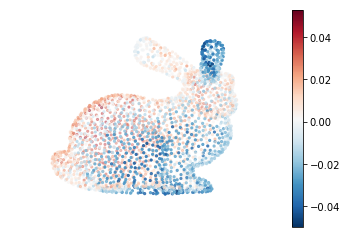

In [155]:
x = G.coords[:, 0] + G.coords[:, 1] + 3 * G.coords[:, 2]
x /= np.linalg.norm(x) 

noise = np.random.randn(n_nodes)
noise /= np.linalg.norm(noise) 

x_noisy = x + 0.3*noise

plot_bunny(x_noisy, vlim=[min(x_noisy), max(x_noisy)])

and plot its graph spectrum:

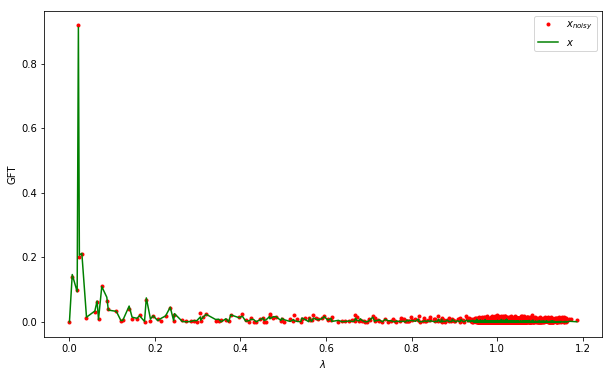

In [163]:
plt.figure(figsize=(10, 6))
plt.plot(lam, np.abs(GFT(x_noisy)), 'r.') 
plt.plot(lam, np.abs(GFT(x)), 'g-')
plt.xlabel('$\lambda$')
plt.ylabel('GFT')
plt.legend(['$x_{noisy}$', '$x$'])

#### Question 13: Graph filters

We will try to extract the signal from the noise using graph filters. Let us start by creating three ideal graph filters.

In [186]:
ideal_lp = np.ones((n_nodes,))
ideal_bp = np.ones((n_nodes,))
ideal_hp = np.ones((n_nodes,))

ideal_lp[lam >= 0.1] = 0  # Low-pass filter with cut-off at lambda=0.1
ideal_bp[lam < 0.1] = 0  # Band-pass filter with cut-offs at lambda=0.1 and lambda=0.5
ideal_bp[lam > 0.5] = 0
ideal_hp[lam <= 1] = 0  # High-pass filter with cut-off at lambda=1

Additionally, create the ideal graph filter that implements the solution of Tikhonov regularization.

In [195]:
alpha = 0.99 / np.max(lam)
print(f"alpha = {alpha}")

ideal_tk = np.ones((n_nodes,)) # Your code here
ideal_tk[lam > alpha] = 0

alpha = 0.8345016957249912


Let's plot the spectral responses:

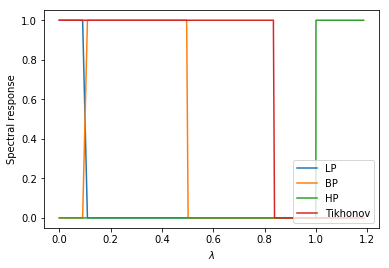

In [196]:
plt.plot(lam, ideal_lp, '-', label='LP')
plt.plot(lam, ideal_bp, '-', label='BP')
plt.plot(lam, ideal_hp, '-', label='HP')
plt.plot(lam, ideal_tk, '-', label='Tikhonov')
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.legend(loc='lower right');

Create a function to filter a signal given an ideal graph filter

In [197]:
x.shape, ideal_tk.shape

((2503,), (2503,))

In [198]:
def ideal_graph_filter(x: np.ndarray, spectral_response: np.ndarray):
    """Return a filtered signal."""
    # Your code here
    for i in range(len(x)):
        if spectral_response[i] == 0:
            x[i] = 0
    return x

Let us visualize the results:

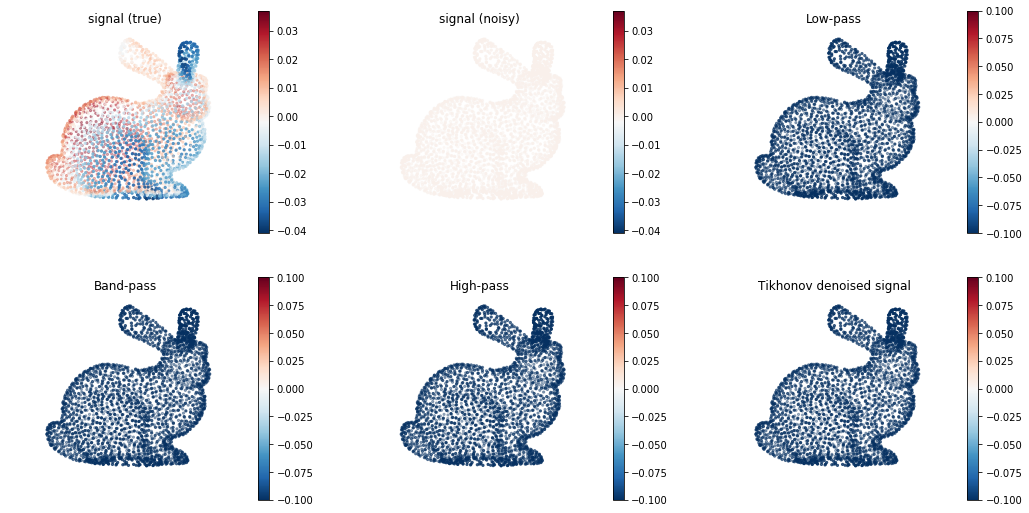

In [199]:
x_lp = ideal_graph_filter(x_noisy,ideal_lp)
x_bp = ideal_graph_filter(x_noisy,ideal_bp)
x_hp = ideal_graph_filter(x_noisy,ideal_hp)
x_tk = ideal_graph_filter(x_noisy,ideal_tk)

plt.figure(figsize=(18, 9))
plt.subplot(231, projection='3d')
plot_bunny(x=x, title='signal (true)', vlim=[min(x), max(x)])
plt.subplot(232, projection='3d')
plot_bunny(x=x_noisy, title='signal (noisy)', vlim=[min(x), max(x)])
plt.subplot(233, projection='3d')
plot_bunny(x=x_lp, title='Low-pass', vlim=[min(x_lp), max(x_lp)])
plt.subplot(234, projection='3d')
plot_bunny(x=x_bp, title='Band-pass', vlim=[min(x_bp), max(x_bp)])
plt.subplot(235, projection='3d')
plot_bunny(x=x_hp, title='High-pass', vlim=[min(x_hp), max(x_hp)])
plt.subplot(236, projection='3d')
plot_bunny(x=x_tk, title='Tikhonov denoised signal', vlim=[min(x_tk), max(x_tk)])

How would you link to the observations you made before about the spectral decomposition of the laplacian?
Also, judging from the results, what type of model prior do you think Tikhonov regularization enforces?

<div class="alert alert-info">
    <b>ANSWER</b> 
</div>

#### Question 14: Polynomial graph filters

We have seen how we can use the GFT to define different filters that enhance or reduce certain frequency bands. However, to do so, we require an explicit eigendecomposition of the graph laplacian, which has a cost $O(n^3)$. For very large graphs this is very intense computationally. We will now see how we can obtain similar results by filtering the signals directly without resorting to an eigendecomposition.

The key idea is to use a polynomial of the graph laplacian to define a graph filter, i.e., $g(L)x=\sum_{k=1}^K \alpha_k L^k x$, and use the fact that the powers of a diagonalizable matrix can be written in terms of powers of its eigenvalues. This is
$$
L^k=(U\Lambda U^T)^k=U\Lambda^k U^T = U\begin{bmatrix}
(\lambda_0)^k &\dots & 0\\
\vdots & \ddots & \vdots\\
0 & \dots & (\lambda_N)^k
\end{bmatrix} U^T.
$$

This means that a polynomial of the graph laplacian acts independently on each eigenvalue of the graph, and has a frequency spectrum of
$$g(\lambda)=\sum_{k=1}^K \alpha_k \lambda^k.$$
Hence,
$$g(L)x=\sum_{k=1}^K \alpha_k L^k x=\sum_{k=1}^K \alpha_k U\Lambda^k U^T x=U \left(\sum_{k=1}^K \alpha_k\Lambda^k \right)U^T x=\operatorname{iGFT}\left(g(\Lambda)\operatorname{GFT}(x)\right).$$

With these ingredients, we have reduced the design of graph filters in the vertex domain to a regression task that approximates a given spectral response by a polynomial. There are multiple ways to do this, but in this assignment we will implement a very simple strategy based on [least-squares regression](https://en.wikipedia.org/wiki/Polynomial_regression#Matrix_form_and_calculation_of_estimates).

Implement a function to find the coefficients of a polynomial that approximates a given ideal filter.
**Hint:** `np.vander` and `np.linalg.lstsq`.

In [ ]:
def fit_polynomial(lam: np.ndarray, order: int, spectral_response: np.ndarray):
    """ Return an array of polynomial coefficients of length 'order'."""
    # Your code here

Implement a function to compute the frequency response of that filter.

In [ ]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    # Your code here

Let us fit the Tikhonov ideal filter with several polynomials of different order.

In [ ]:
plt.plot(lam, ideal_tk)
orders = [1, 2, 3, 5, 10, 20]
for order in orders:    
    coeff_tk = fit_polynomial(lam, order, ideal_tk)
    plt.plot(lam, polynomial_graph_filter_response(coeff_tk, lam))

plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.legend(orders)

So far, we have only defined a way to compute the coefficients of our laplacian polynomial. Let us now compute our graph filter.

In [ ]:
def polynomial_graph_filter(coeff: np.array, laplacian: np.ndarray):
    """ Return the laplacian polynomial with coefficients 'coeff'. """
    # Your code here

Based on the previous plot, choose a filter order that achieves (in your opinion) a good tradeoff in terms of computational complexity and response accuracy.

In [ ]:
order =  # Your code here
coeff_tk = fit_polynomial(lam, order, ideal_tk)
g_tk = polynomial_graph_filter(coeff_tk, laplacian)

#### Question 15: ARMA filter

As you have seen in class, polynomial graph filters are only one of the ways in which you can approximate ideal graph filters. 
In this sense, ARMA filters are a natural way to implement Tikhonov denoising on graphs.
Let us recall the general solution of the Tikhonov regularized denoising problem 

$$y=(I+\alpha L)^{-1}x. $$

With a little bit of algebra manipulation we can rewrite this expression as
$$
    y = -\alpha L y + x,
$$
from which we can derive the iterative algorithm
$$
    y_k = -\alpha L y_{k-1} + x\qquad k=1,2,\dots
$$
which is guaranteed to converge as long as $\alpha \lambda_{max} < 1$.

Implement the ARMA version of Tikhonov regularization.

In [ ]:
def arma_tikhonov(x: np.ndarray, laplacian: np.ndarray, alpha: float, max_iter=50):
    """ Return an array of the same shape as x."""
    # Your code here

Filter the previous noisy graph signal with the polynomial and ARMA approximations of the ideal Tikhonov filter.

In [ ]:
x_tk_polynomial =  # Your code here
x_tk_arma = arma_tikhonov(x_noisy, laplacian, alpha)

Let us compare with the previous version.

In [ ]:
plt.figure(figsize=(18, 4))
plt.subplot(131, projection='3d')
plot_bunny(x_tk, title='Ideal filter', vlim=[min(x_tk), max(x_tk)])
plt.subplot(132, projection='3d')
plot_bunny(x_tk_polynomial, title='Polynomial filter', vlim=[min(x_tk), max(x_tk)])
plt.subplot(133, projection='3d')
plot_bunny(x_tk_arma, title='ARMA filter', vlim=[min(x_tk), max(x_tk)])

<a id='ml'></a>
## Part III: Machine Learning on Graphs

So far, we have only played with toy examples. Let us see the use of these tools in practice! In particular, let us see how we can use some graph filters to construct features to feed a classifier. For this part of the assignment we will import some extra packages.

In [40]:
import time

import networkx as nx
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl.function as fn
from dgl import DGLGraph
from dgl.data.citation_graph import load_cora

np.random.seed(0)
torch.manual_seed(1)

We will use the CORA dataset and the citation graph that we created in Assignment 1. However, to simplify the next tasks we will directly use the preprocessed version of this dataset contained within the Deep Graph Library (DGL).

In this assignment, we will interpret CORA's features as multidimensional graph signals living on the citation graph.
Our task is to design a classifier that uses these features and the geometry of the graph can identify the type of paper each node represents.

The goal of this exercise is to do semi-supervised learning on graphs.
We assume that we know to which scientific field a small subset of the papers belongs (the ones contained in `train_mask`).
The goal is to predict to which field the other papers belong, using both the citation graph and the bag-of-word representation of each paper.

In [77]:
cora = load_cora()

features = torch.FloatTensor(cora.features)    # Feature vector for each paper
labels = torch.LongTensor(cora.labels)         # The field to which each paper belongs

train_mask = torch.BoolTensor(cora.train_mask) # Mask of nodes selected for training
val_mask = torch.BoolTensor(cora.val_mask)     # Mask of nodes selected for validation
test_mask = torch.BoolTensor(cora.test_mask)   # Mask of nodes selected for testing

in_feats = features.shape[1]
n_classes = cora.num_labels
n_edges = cora.graph.number_of_edges()

graph = cora.graph
adjacency = np.asarray(nx.to_numpy_matrix(graph))
n_nodes = adjacency.shape[0]

In [78]:
features.shape

torch.Size([2708, 1433])

In [79]:
labels.shape

torch.Size([2708])

In [80]:
train_mask.shape

torch.Size([2708])

In [81]:
n_nodes

2708

For this exercise we will use the normalized laplacian.

In [82]:
laplacian = compute_laplacian(adjacency, normalize=True)
lam, U = spectral_decomposition(laplacian)
lam_max = np.max(lam)

#### Question 16: Logistic regression

The simplest classification method consists in ignoring the citation graph and trying to classify the papers using only the features.
In this case, the problem is viewed as a standard classification task.
To train our classifier we will select a few nodes in our graph for training and fit a [logistic regression classifier](https://en.wikipedia.org/wiki/Logistic_regression) on them.
To avoid overfitting to the test set when we do hyperparameter tuning, we will also select a validation set.
And finally, we will test our classifier on the rest of the nodes.
**Hint:** use `sklearn.linear_model.LogisticRegression`.

In [83]:
train_features = features[train_mask]
train_labels = labels[train_mask]
val_features = features[val_mask]
val_labels = labels[val_mask]
test_features = features[test_mask]
test_labels = labels[test_mask]

In [84]:
train_features.shape, train_labels.shape

(torch.Size([140, 1433]), torch.Size([140]))

0.601 0.66


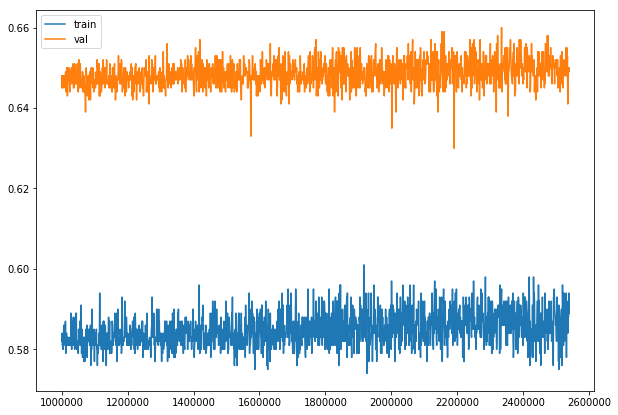

In [135]:
# Fit a logistic regression model
# Your code here
from sklearn.metrics import accuracy_score
# 8e6
#C_param_range = [0.001,0.01,0.1,1,10,100, 1000, 5000, 1e4, 1e6, 8e6, 9e6, 1e7, 2e7,1e8]

try:
    C_param_range = np.arange(1e6, 1e8, 1e3)
    accuracies_train = []
    accuracies_val   = []
    params = []

    j = 0
    for i in C_param_range:

        # Apply logistic regression model to training data
        lr = LogisticRegression(penalty = 'l2', C = i, random_state = 0, solver='lbfgs', multi_class='multinomial', max_iter=1e5)

        # Predict using model
        y_pred_train = lr.fit(train_features, train_labels).predict(test_features)
        y_pred_val   = lr.fit(val_features, val_labels).predict(test_features)

        # Calculate accuracy
        acc_train = accuracy_score(test_labels, y_pred_train)
        acc_val   = accuracy_score(test_labels, y_pred_val)
        
        # Collect
        accuracies_train.append(acc_train)
        accuracies_val.append(acc_val)
        params.append(i)

except KeyboardInterrupt:
    plt.figure(figsize=(10,7))
    plt.plot(params, accuracies_train, label="train")
    plt.plot(params, accuracies_val, label="val")
    plt.legend()
    print(max(accuracies_train), max(accuracies_val))

In [136]:
accuracies_mean = [ (t+v)/2 for (t, v) in zip(accuracies_train, accuracies_val)]
i = (np.argmax(accuracies_mean))
accuracies_mean[i], params[i]

(0.6275, 2335000.0)

In [138]:
# (0.601, 1917000.0)
# Train accuracy 1.0000 | Validation accuracy 0.5800 | Test accuracy 0.6010
lr = LogisticRegression(penalty = 'l2', C = params[i], random_state = 0, solver='lbfgs', multi_class='multinomial', max_iter=1e5)
lr.fit(train_features, train_labels)
    
train_acc = lr.score(train_features, train_labels) # Your code here
val_acc =  lr.score(val_features, val_labels) # Your code here
test_acc = lr.score(test_features, test_labels)  # Your code here

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 1.0000 | Validation accuracy 0.5800 | Test accuracy 0.6010


#### Question 17: Handcrafted graph filters

That's not a bad start! Now, let's try to improve a bit the results by taking into account the graph structure using tools from GSP. For this purpose, we will design a handcrafted filter that will be used to denoise the signal, before feeding it to a logistic regression.

However, before we start, what hypothesis can you make on the spectral properties of the denoised signal?

<div class="alert alert-info">
    <b>ANSWER</b> 
</div>

Based on this prior, design an ideal filter response that you believe could enhance important features of the graph. 

**Note:** you just need to design one graph filter that we will apply to all features. Don't design a different filter for each feature. 

**Note:** finding the right filter can be very challenging, don't worry if you can't find it. Just make sure you experiment with a few configurations and parameters.

In [139]:
ideal_filter = lambda x: x  # Store your spectral response here

Choose a filter order to approximate your filter using laplacian polynomials.

In [140]:
order =  2 # Your code here

coeff = fit_polynomial(lam, order, ideal_filter)
graph_filter = polynomial_graph_filter(coeff, laplacian)

NameError: name 'fit_polynomial' is not defined

Let's plot the frequency response of your spectral template and its polynomial approximation.

In [ ]:
plt.plot(lam, ideal_filter)
plt.plot(lam, polynomial_graph_filter_response(coeff, lam))
plt.legend(['Ideal', 'Polynomial'])
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')

Now, let's create the new features.

In [ ]:
filtered_features = graph_filter @ features.numpy()

train_features = filtered_features[train_mask,:]
train_labels = labels[train_mask]

val_features = filtered_features[val_mask,:]
val_labels = labels[val_mask]

test_features = filtered_features[test_mask,:]
test_labels = labels[test_mask]

Train another logistic regression classifier on the new features. Remember to play with the regularization parameters to achieve a well performing model.

In [ ]:
# Your code here

Evaluate your model.

In [ ]:
train_acc =  # Your code here
val_acc =  # Your code here
test_acc =  # Your code here

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

#### Question 18: Graph convolutional networks

By now, you will probably have seen that it is challenging to find the right combination of spectral response, filter parameters and regularization method. And in most cases, this is a painstaking job. Wouldn't it be great to automate these tasks?

Fortunately, this is possible if we use the right tools! Specifically, we will see that Graph Convolutional Networks are a great framework to automatize the feature extraction method.

In this exercise, we will follow the same classification pipeline as above, but instead of hand-crafting our filter we will let `PyTorch` find the coefficients for us using gradient descent.

In this section, most of the code is already written. Try to understand it and to play with some parameters. It may be useful if you want to solve some learning task in your project.

We start by constructing a `LaplacianPolynomial` model in `DGL`. It computes the function: $f(X) = \sum_{i=1}^{k} \alpha_i L^i X \theta$ where the trainable parameters are the coefficients $\alpha_i$ and the matrix $\theta$. This function can be interpreted as a filtering of $X$ by $\sum_{i=1}^{k} \alpha_i L^i$ followed by a linear layer.

In [29]:
class LaplacianPolynomial(nn.Module):
    def __init__(self,
                 in_feats: int,
                 out_feats: int,
                 k: int,
                 dropout_prob: float,
                 norm=True):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        self._norm = norm
        # Contains the weights learned by the Laplacian polynomial
        self.pol_weights = nn.Parameter(torch.Tensor(self._k + 1))
        # Contains the weights learned by the logistic regression (without bias)
        self.logr_weights = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.manual_seed(0)
        torch.nn.init.xavier_uniform_(self.logr_weights, gain=0.01)
        torch.nn.init.normal_(self.pol_weights, mean=0.0, std=1e-3)

    def forward(self, graph, feat):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.

        Parameters
        ----------
        graph (DGLGraph) : The graph.
        feat (torch.Tensor): The input feature

        Returns
        -------
        (torch.Tensor) The output feature
        """
        feat = self.dropout(feat)
        graph = graph.local_var()
        
        # D^(-1/2)
        norm = torch.pow(graph.in_degrees().float().clamp(min=1), -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, self.logr_weights)

        result = self.pol_weights[0] * feat.clone()

        for i in range(1, self._k + 1):
            old_feat = feat.clone()
            if self._norm:
                feat = feat * norm
            graph.ndata['h'] = feat
            # Feat is not modified in place
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            if self._norm:
                graph.ndata['h'] = graph.ndata['h'] * norm

            feat = old_feat - graph.ndata['h']
            result += self.pol_weights[i] * feat

        return result

    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        return summary.format(**self.__dict__)

Once we have are model ready we just need to create a function that performs one step of our training loop, and another one that evaluates our model.

In [30]:
def train(model, g, features, labels, loss_fcn, train_mask, optimizer):
    model.train()  # Activate dropout
    
    logits = model(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def evaluate(model, g, features, labels, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

Choose the training parameters.

In [31]:
pol_order = 3
lr = 0.2
weight_decay = 5e-6
n_epochs = 1000
p_dropout = 0.8

And train the classifier end to end.

In [32]:
graph = DGLGraph(cora.graph)

model = LaplacianPolynomial(in_feats, n_classes, pol_order, p_dropout)

loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    if epoch >= 3:
        t0 = time.time()
    loss = train(model, graph, features, labels, loss_fcn, train_mask, optimizer)

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, graph, features, labels, val_mask)
    print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.4f} | Val Accuracy {:.4f}". format(
            epoch, np.mean(dur), loss.item(), acc))

print()
acc = evaluate(model, graph, features, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

/home/jelena/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jelena/.local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Time(s) nan | Train Loss 1.9459 | Val Accuracy 0.2667
Epoch 00001 | Time(s) nan | Train Loss 1.9221 | Val Accuracy 0.2533
Epoch 00002 | Time(s) nan | Train Loss 1.8533 | Val Accuracy 0.2467
Epoch 00003 | Time(s) 0.0132 | Train Loss 1.7058 | Val Accuracy 0.2700
Epoch 00004 | Time(s) 0.0132 | Train Loss 1.4878 | Val Accuracy 0.2900
Epoch 00005 | Time(s) 0.0132 | Train Loss 1.3438 | Val Accuracy 0.2967
Epoch 00006 | Time(s) 0.0132 | Train Loss 1.0504 | Val Accuracy 0.3067
Epoch 00007 | Time(s) 0.0132 | Train Loss 1.1285 | Val Accuracy 0.3167
Epoch 00008 | Time(s) 0.0132 | Train Loss 0.8329 | Val Accuracy 0.3200
Epoch 00009 | Time(s) 0.0132 | Train Loss 0.9067 | Val Accuracy 0.3167
Epoch 00010 | Time(s) 0.0132 | Train Loss 0.8401 | Val Accuracy 0.3133
Epoch 00011 | Time(s) 0.0132 | Train Loss 1.0514 | Val Accuracy 0.3133
Epoch 00012 | Time(s) 0.0132 | Train Loss 1.1378 | Val Accuracy 0.3300
Epoch 00013 | Time(s) 0.0133 | Train Loss 1.1666 | Val Accuracy 0.3200
Epoch 00014 | T

Epoch 00124 | Time(s) 0.0151 | Train Loss 0.1703 | Val Accuracy 0.4833
Epoch 00125 | Time(s) 0.0151 | Train Loss 0.1530 | Val Accuracy 0.4833
Epoch 00126 | Time(s) 0.0151 | Train Loss 0.1862 | Val Accuracy 0.5067
Epoch 00127 | Time(s) 0.0151 | Train Loss 0.1641 | Val Accuracy 0.5200
Epoch 00128 | Time(s) 0.0151 | Train Loss 0.2754 | Val Accuracy 0.5233
Epoch 00129 | Time(s) 0.0151 | Train Loss 0.2412 | Val Accuracy 0.5433
Epoch 00130 | Time(s) 0.0150 | Train Loss 0.2384 | Val Accuracy 0.5467
Epoch 00131 | Time(s) 0.0150 | Train Loss 0.1321 | Val Accuracy 0.5633
Epoch 00132 | Time(s) 0.0150 | Train Loss 0.1747 | Val Accuracy 0.5467
Epoch 00133 | Time(s) 0.0150 | Train Loss 0.1293 | Val Accuracy 0.5300
Epoch 00134 | Time(s) 0.0150 | Train Loss 0.1605 | Val Accuracy 0.5167
Epoch 00135 | Time(s) 0.0150 | Train Loss 0.1850 | Val Accuracy 0.5033
Epoch 00136 | Time(s) 0.0150 | Train Loss 0.1121 | Val Accuracy 0.4967
Epoch 00137 | Time(s) 0.0150 | Train Loss 0.2143 | Val Accuracy 0.4967
Epoch 

Epoch 00244 | Time(s) 0.0147 | Train Loss 0.0449 | Val Accuracy 0.7200
Epoch 00245 | Time(s) 0.0147 | Train Loss 0.0579 | Val Accuracy 0.7200
Epoch 00246 | Time(s) 0.0147 | Train Loss 0.1111 | Val Accuracy 0.7200
Epoch 00247 | Time(s) 0.0147 | Train Loss 0.0614 | Val Accuracy 0.7200
Epoch 00248 | Time(s) 0.0147 | Train Loss 0.1068 | Val Accuracy 0.7233
Epoch 00249 | Time(s) 0.0147 | Train Loss 0.0222 | Val Accuracy 0.7233
Epoch 00250 | Time(s) 0.0147 | Train Loss 0.1009 | Val Accuracy 0.7267
Epoch 00251 | Time(s) 0.0147 | Train Loss 0.0750 | Val Accuracy 0.7300
Epoch 00252 | Time(s) 0.0146 | Train Loss 0.0860 | Val Accuracy 0.7300
Epoch 00253 | Time(s) 0.0146 | Train Loss 0.0453 | Val Accuracy 0.7267
Epoch 00254 | Time(s) 0.0146 | Train Loss 0.0765 | Val Accuracy 0.7333
Epoch 00255 | Time(s) 0.0146 | Train Loss 0.0535 | Val Accuracy 0.7300
Epoch 00256 | Time(s) 0.0146 | Train Loss 0.0808 | Val Accuracy 0.7300
Epoch 00257 | Time(s) 0.0146 | Train Loss 0.0988 | Val Accuracy 0.7267
Epoch 

Epoch 00368 | Time(s) 0.0149 | Train Loss 0.0363 | Val Accuracy 0.7733
Epoch 00369 | Time(s) 0.0149 | Train Loss 0.0350 | Val Accuracy 0.7733
Epoch 00370 | Time(s) 0.0149 | Train Loss 0.0577 | Val Accuracy 0.7667
Epoch 00371 | Time(s) 0.0149 | Train Loss 0.0490 | Val Accuracy 0.7633
Epoch 00372 | Time(s) 0.0149 | Train Loss 0.1220 | Val Accuracy 0.7667
Epoch 00373 | Time(s) 0.0149 | Train Loss 0.0696 | Val Accuracy 0.7533
Epoch 00374 | Time(s) 0.0149 | Train Loss 0.0723 | Val Accuracy 0.7533
Epoch 00375 | Time(s) 0.0149 | Train Loss 0.1220 | Val Accuracy 0.7567
Epoch 00376 | Time(s) 0.0149 | Train Loss 0.0374 | Val Accuracy 0.7567
Epoch 00377 | Time(s) 0.0149 | Train Loss 0.0702 | Val Accuracy 0.7533
Epoch 00378 | Time(s) 0.0149 | Train Loss 0.0928 | Val Accuracy 0.7533
Epoch 00379 | Time(s) 0.0149 | Train Loss 0.0523 | Val Accuracy 0.7500
Epoch 00380 | Time(s) 0.0149 | Train Loss 0.0710 | Val Accuracy 0.7500
Epoch 00381 | Time(s) 0.0149 | Train Loss 0.0704 | Val Accuracy 0.7500
Epoch 

Epoch 00486 | Time(s) 0.0151 | Train Loss 0.0529 | Val Accuracy 0.7767
Epoch 00487 | Time(s) 0.0151 | Train Loss 0.0508 | Val Accuracy 0.7767
Epoch 00488 | Time(s) 0.0151 | Train Loss 0.0361 | Val Accuracy 0.7733
Epoch 00489 | Time(s) 0.0151 | Train Loss 0.0627 | Val Accuracy 0.7733
Epoch 00490 | Time(s) 0.0151 | Train Loss 0.0225 | Val Accuracy 0.7733
Epoch 00491 | Time(s) 0.0151 | Train Loss 0.0431 | Val Accuracy 0.7700
Epoch 00492 | Time(s) 0.0151 | Train Loss 0.0213 | Val Accuracy 0.7667
Epoch 00493 | Time(s) 0.0151 | Train Loss 0.0211 | Val Accuracy 0.7633
Epoch 00494 | Time(s) 0.0151 | Train Loss 0.0507 | Val Accuracy 0.7633
Epoch 00495 | Time(s) 0.0151 | Train Loss 0.0869 | Val Accuracy 0.7633
Epoch 00496 | Time(s) 0.0151 | Train Loss 0.0601 | Val Accuracy 0.7667
Epoch 00497 | Time(s) 0.0151 | Train Loss 0.0509 | Val Accuracy 0.7700
Epoch 00498 | Time(s) 0.0151 | Train Loss 0.0534 | Val Accuracy 0.7667
Epoch 00499 | Time(s) 0.0151 | Train Loss 0.0317 | Val Accuracy 0.7667
Epoch 

Epoch 00611 | Time(s) 0.0151 | Train Loss 0.0451 | Val Accuracy 0.7967
Epoch 00612 | Time(s) 0.0151 | Train Loss 0.0119 | Val Accuracy 0.7933
Epoch 00613 | Time(s) 0.0151 | Train Loss 0.0399 | Val Accuracy 0.7933
Epoch 00614 | Time(s) 0.0151 | Train Loss 0.0349 | Val Accuracy 0.7933
Epoch 00615 | Time(s) 0.0151 | Train Loss 0.0446 | Val Accuracy 0.7867
Epoch 00616 | Time(s) 0.0151 | Train Loss 0.0532 | Val Accuracy 0.7867
Epoch 00617 | Time(s) 0.0151 | Train Loss 0.0339 | Val Accuracy 0.7867
Epoch 00618 | Time(s) 0.0151 | Train Loss 0.0627 | Val Accuracy 0.7867
Epoch 00619 | Time(s) 0.0151 | Train Loss 0.0201 | Val Accuracy 0.7833
Epoch 00620 | Time(s) 0.0151 | Train Loss 0.0456 | Val Accuracy 0.7867
Epoch 00621 | Time(s) 0.0151 | Train Loss 0.0473 | Val Accuracy 0.7867
Epoch 00622 | Time(s) 0.0151 | Train Loss 0.0164 | Val Accuracy 0.7900
Epoch 00623 | Time(s) 0.0151 | Train Loss 0.0317 | Val Accuracy 0.7933
Epoch 00624 | Time(s) 0.0151 | Train Loss 0.0619 | Val Accuracy 0.7933
Epoch 

Epoch 00738 | Time(s) 0.0151 | Train Loss 0.0507 | Val Accuracy 0.8100
Epoch 00739 | Time(s) 0.0151 | Train Loss 0.0122 | Val Accuracy 0.8133
Epoch 00740 | Time(s) 0.0151 | Train Loss 0.0435 | Val Accuracy 0.8167
Epoch 00741 | Time(s) 0.0151 | Train Loss 0.0401 | Val Accuracy 0.8100
Epoch 00742 | Time(s) 0.0151 | Train Loss 0.0701 | Val Accuracy 0.8133
Epoch 00743 | Time(s) 0.0151 | Train Loss 0.0470 | Val Accuracy 0.8033
Epoch 00744 | Time(s) 0.0151 | Train Loss 0.0331 | Val Accuracy 0.8000
Epoch 00745 | Time(s) 0.0151 | Train Loss 0.0319 | Val Accuracy 0.7967
Epoch 00746 | Time(s) 0.0151 | Train Loss 0.0333 | Val Accuracy 0.7900
Epoch 00747 | Time(s) 0.0151 | Train Loss 0.0602 | Val Accuracy 0.7967
Epoch 00748 | Time(s) 0.0151 | Train Loss 0.0548 | Val Accuracy 0.8000
Epoch 00749 | Time(s) 0.0151 | Train Loss 0.0369 | Val Accuracy 0.7933
Epoch 00750 | Time(s) 0.0151 | Train Loss 0.0253 | Val Accuracy 0.7900
Epoch 00751 | Time(s) 0.0151 | Train Loss 0.0437 | Val Accuracy 0.7867
Epoch 

Epoch 00865 | Time(s) 0.0150 | Train Loss 0.0830 | Val Accuracy 0.8033
Epoch 00866 | Time(s) 0.0150 | Train Loss 0.0395 | Val Accuracy 0.8033
Epoch 00867 | Time(s) 0.0150 | Train Loss 0.0139 | Val Accuracy 0.8133
Epoch 00868 | Time(s) 0.0150 | Train Loss 0.0210 | Val Accuracy 0.8133
Epoch 00869 | Time(s) 0.0150 | Train Loss 0.0854 | Val Accuracy 0.8033
Epoch 00870 | Time(s) 0.0150 | Train Loss 0.0319 | Val Accuracy 0.8000
Epoch 00871 | Time(s) 0.0150 | Train Loss 0.0746 | Val Accuracy 0.7967
Epoch 00872 | Time(s) 0.0150 | Train Loss 0.0784 | Val Accuracy 0.7833
Epoch 00873 | Time(s) 0.0150 | Train Loss 0.1305 | Val Accuracy 0.7900
Epoch 00874 | Time(s) 0.0150 | Train Loss 0.1299 | Val Accuracy 0.7867
Epoch 00875 | Time(s) 0.0150 | Train Loss 0.0527 | Val Accuracy 0.7933
Epoch 00876 | Time(s) 0.0150 | Train Loss 0.0504 | Val Accuracy 0.8000
Epoch 00877 | Time(s) 0.0150 | Train Loss 0.0215 | Val Accuracy 0.8000
Epoch 00878 | Time(s) 0.0150 | Train Loss 0.0531 | Val Accuracy 0.8067
Epoch 

Epoch 00985 | Time(s) 0.0149 | Train Loss 0.0235 | Val Accuracy 0.7967
Epoch 00986 | Time(s) 0.0149 | Train Loss 0.0364 | Val Accuracy 0.7933
Epoch 00987 | Time(s) 0.0149 | Train Loss 0.0339 | Val Accuracy 0.7900
Epoch 00988 | Time(s) 0.0149 | Train Loss 0.0563 | Val Accuracy 0.7900
Epoch 00989 | Time(s) 0.0149 | Train Loss 0.0196 | Val Accuracy 0.7833
Epoch 00990 | Time(s) 0.0149 | Train Loss 0.0596 | Val Accuracy 0.7833
Epoch 00991 | Time(s) 0.0149 | Train Loss 0.0367 | Val Accuracy 0.7833
Epoch 00992 | Time(s) 0.0149 | Train Loss 0.0713 | Val Accuracy 0.7833
Epoch 00993 | Time(s) 0.0149 | Train Loss 0.0646 | Val Accuracy 0.7867
Epoch 00994 | Time(s) 0.0149 | Train Loss 0.0432 | Val Accuracy 0.7900
Epoch 00995 | Time(s) 0.0149 | Train Loss 0.0657 | Val Accuracy 0.7900
Epoch 00996 | Time(s) 0.0149 | Train Loss 0.0214 | Val Accuracy 0.7900
Epoch 00997 | Time(s) 0.0149 | Train Loss 0.0507 | Val Accuracy 0.7833
Epoch 00998 | Time(s) 0.0149 | Train Loss 0.0816 | Val Accuracy 0.7833
Epoch 

Trained this way our GCN based on polynomials of the laplacian is a black box. Fortunately, however, the only difference between this shallow model and our previous classifier is the way we chose the filter coefficients.

Let's see what the network learned.
Print the coefficients of the learned filter.

In [48]:
coeff_gcn = list(model.parameters())[1].detach().numpy() # Your code here
print(coeff_gcn)

[[-2.1978457  -0.32308304  0.29399404 ...  2.1988966  -1.3788197
   2.681601  ]
 [-0.26301125 -1.1772909  -1.0847187  ... -0.8109463  -0.52605605
   2.8203847 ]
 [-2.2775044   1.3138794   3.034728   ...  1.5255923   1.3054273
  -4.160872  ]
 ...
 [-1.4237431   0.01095638  2.4790602  ... -0.11770539  1.4404694
  -3.528302  ]
 [-0.69946086 -0.5933067   0.91946125 ...  1.8660022   1.7793654
  -0.82221055]
 [ 0.7483965   0.10034925 -3.3145382  ...  2.3172145   0.12731531
   1.0398918 ]]


To interpret the model we can plot the frequency response of the learned filter.

In [35]:
plt.semilogy(lam, np.abs(polynomial_graph_filter_response(coeff_gcn, lam)))
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response (db)')

#### Question 19

As we said, the whole classification pipeline of the previous exercise is identical to the one we tried before: Graph filtering + Logistic regression. The only difference lies in the way we chose the filter coefficients. First we were choosing them manually, and now, we let `PyTorch` find them for us. However, if everything is correct we should be able to use this filter to construct new hand-crafted features and train a logistic regression model that achieves good accuracy on the training set. Let's do that!

Use the learned coefficients to train a new feature extractor:

In [ ]:
graph_gcn_filter =  # Your code here

Let's extract the new features by filtering the data:

In [ ]:
features_gcn = graph_gcn_filter @ features.numpy()

train_features_gcn = features_gcn[train_mask,:]
train_labels = labels[train_mask]
val_features_gcn = features_gcn[val_mask,:]
val_labels = labels[val_mask]
test_features_gcn = features_gcn[test_mask,:]
test_labels = labels[test_mask]

Train a logistic regression on these features:

In [ ]:
# Your code here

Finally, let's evaluate this model:

In [ ]:
train_acc =  # Your code here
val_acc =  # Your code here
test_acc =  # Your code here

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

The performance of this model may not be exactly the same as the one obtained with Pytorch. What are the differences in the training procedure that can explain this gap?

<div class="alert alert-info">
    <b>ANSWER</b> 
</div>